C. elegans application - hypodermis and seam
----
Preprocessing, merging annotations and plotting them on provided embeddings. 

This data comes from [Packer et al., Science 2019](https://science.sciencemag.org/content/365/6459/eaax1971). 

# Preliminaries

## Dependecy notebooks

This is the first of a series of notebooks. 

## Import packages

If you want modules to be automatically reloaded when you call them, use `autoreload`:

In [1]:
%load_ext autoreload
%autoreload 2

Import packages

In [2]:
# import standard packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# import single-cell packages
import scanpy as sc
import scvelo as scv
import cellrank as cr
from cellrank._utils._colors import _convert_to_hex_colors

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3 

Global seed set to 0


## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [3]:
cr.logging.print_versions()

cellrank==1.5.2.dev206+ga2748bea scanpy==1.9.3 anndata==0.8.0 numpy==1.24.2 numba==0.57.0rc1 scipy==1.10.1 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 scvelo==0.3.0 pygam==0.8.0 matplotlib==3.7.0 seaborn==0.12.2


In [4]:
cr.logging.print_version_and_date()

Running CellRank 1.5.2.dev206+ga2748bea, on 2023-07-17 16:17.


## Set up paths

In [5]:
sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

# adjust directories
DATA_DIR = DATA_DIR / "cytotrace_kernel" / "validation"
FIG_DIR = FIG_DIR / "cytotrace_kernel" / "validation"

scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Utility functions

In [6]:
def remap_colors(adata, key, color_map='gnuplot'):
    """Utlility to change the coloring """
    n_colors = len(adata.obs[key].cat.categories)
    adata.uns[f"{key}_colors"] = _convert_to_hex_colors(sns.color_palette(color_map, n_colors=n_colors))

## Set global parameters

Set some plotting parameters.

In [7]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

Set other global parameters

In [8]:
# should figures just be displayed or also saved?
save_figure = False


If there are other global parameters for this analysis, put them here as well. 

## Load the data

Import the data

In [9]:
adata = sc.read(DATA_DIR / "cytotrace_examples" / "Muscle_and_mesoderm_celegans_matrix.txt").T
adata

AnnData object with n_obs × n_vars = 22370 × 20222

Import metadata

In [10]:
metadata = pd.read_csv(DATA_DIR / "cytotrace_examples" / "Muscle_and_mesoderm_celegans_metadata.txt", sep='\t', skiprows=None, 
                       index_col=None)
print(metadata.shape)
metadata.head()

(22370, 5)


,Phenotype,Ground_truth,Component_1,Component_2,CytoTRACE
AAACCTGAGACAATAC-300.1.1,MSxpappp,380,0.804078,0.745510,577
AAACCTGAGTTGAGTA-300.1.1,Dxap,280,1.346703,0.883214,1003
AAACCTGGTCTGGAGA-300.1.1,Dxxax,320,1.309402,0.934734,746
AAACCTGGTTATGCGT-300.1.1,MSxppppx,335,1.159112,0.954778,711
AAACGGGTCGTTACGA-300.1.1,MSxapppp,330,0.935460,0.972182,715


## Merge annotations

Merge the study annotation

In [11]:
# join annotations
obs_updated = adata.obs.join(metadata, how='inner')

# restrict anndata to subset
adata = adata[obs_updated.index].copy()

# make sure the ordering of cells matches
assert((adata.obs_names == obs_updated.index).all()), "Annotation mismatch"

# copy new annotations into adata
adata.obs = obs_updated
adata

AnnData object with n_obs × n_vars = 22370 × 20222
    obs: 'Phenotype', 'Ground_truth', 'Component_1', 'Component_2', 'CytoTRACE'

Make categorical

In [12]:
adata.obs['Phenotype'] = adata.obs['Phenotype'].astype('category')

Define a pseudotime based on the original CytoTrace score:

In [13]:
adata.obs['original_ct_pseudotime'] = 1 - adata.obs['CytoTRACE'].values / adata.obs['CytoTRACE'].values.max()

Get a numerical version of the ground truth for easier plotting:

In [14]:
adata.obs['Ground_truth_cont'] = adata.obs['Ground_truth'].astype(float).values.copy()

Make both ct ground truth a categorical, and change some color schemes. 

In [15]:
adata.obs['Ground_truth'] = adata.obs['Ground_truth'].astype('category')
remap_colors(adata, key='Ground_truth', color_map='gnuplot2')

Move embeddings to `.obsm`:

In [16]:
# cyto_trace = whatever they used
ct_embedding = np.concatenate((adata.obs['Component_1'].values[:, None],
                               adata.obs['Component_2'].values[:, None]),
                               axis=1)
adata.obsm['X_ct'] = ct_embedding

## Plot embeddings, check annotations

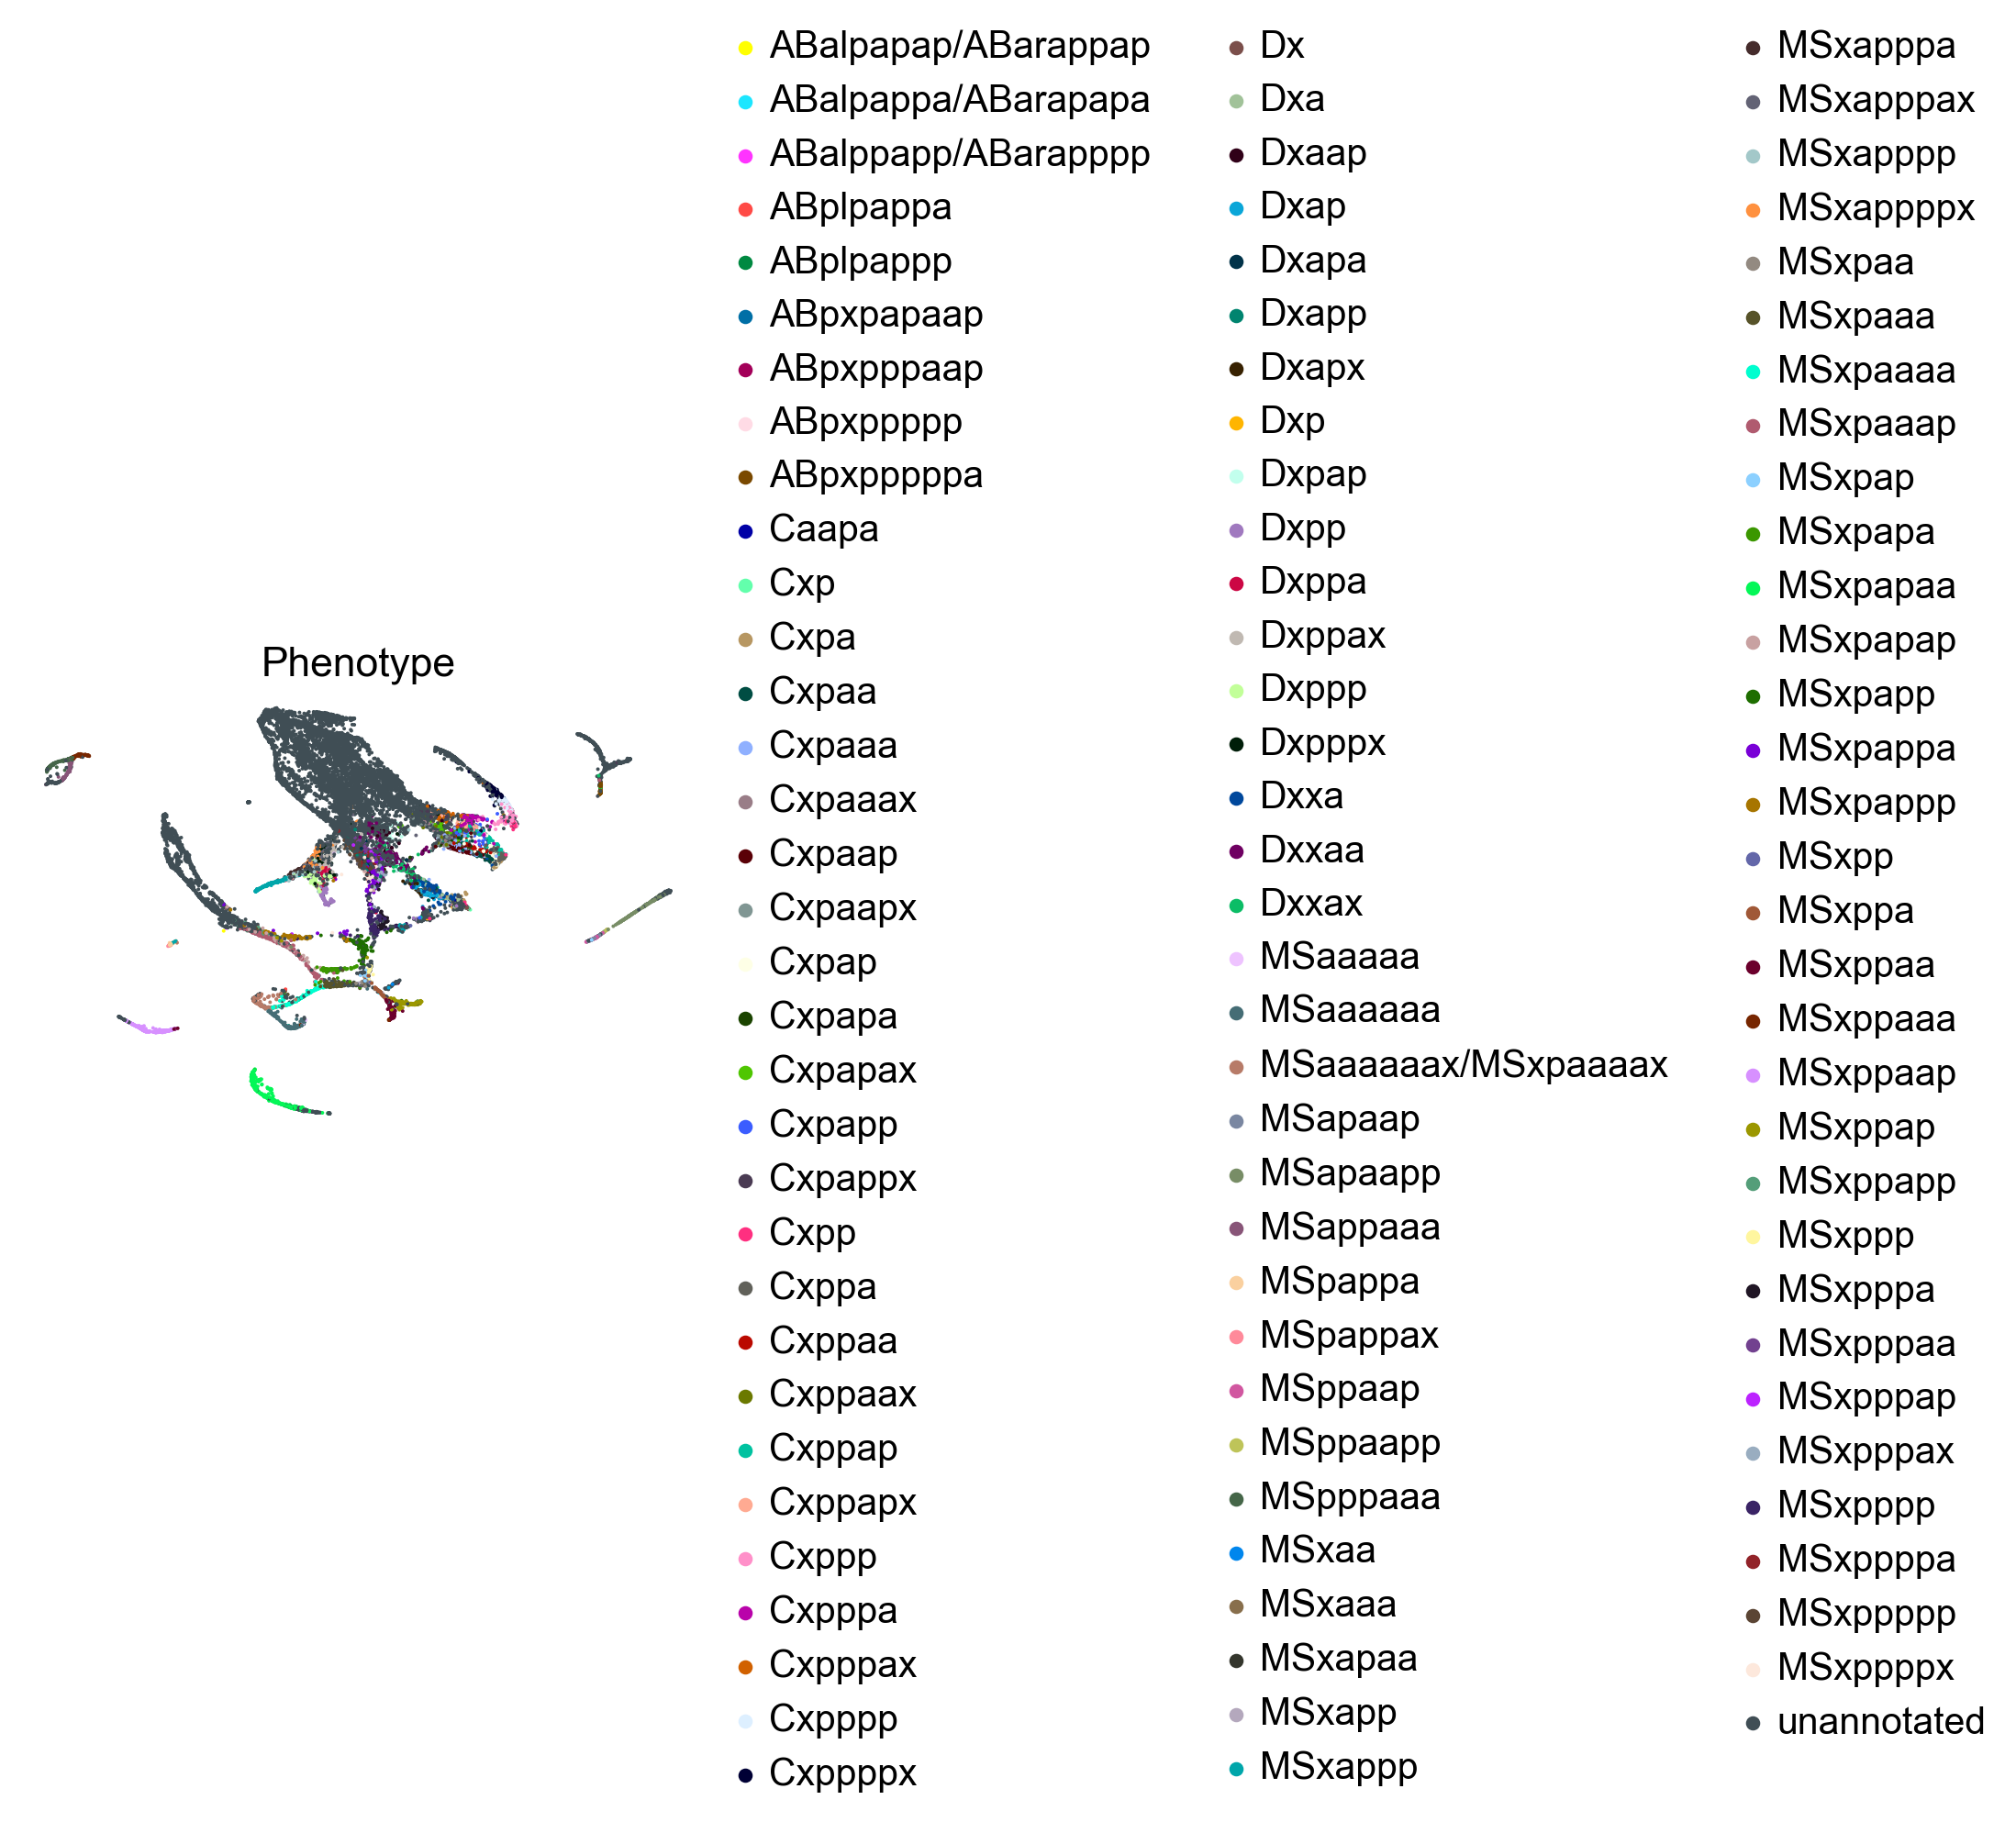

In [17]:
scv.pl.scatter(adata, c=['Phenotype'], basis='ct',
               legend_loc='right')

How many district cell types are there?

In [18]:
len(adata.obs['Phenotype'].cat.categories)

98

In total, there are 502 in the original dataset. 

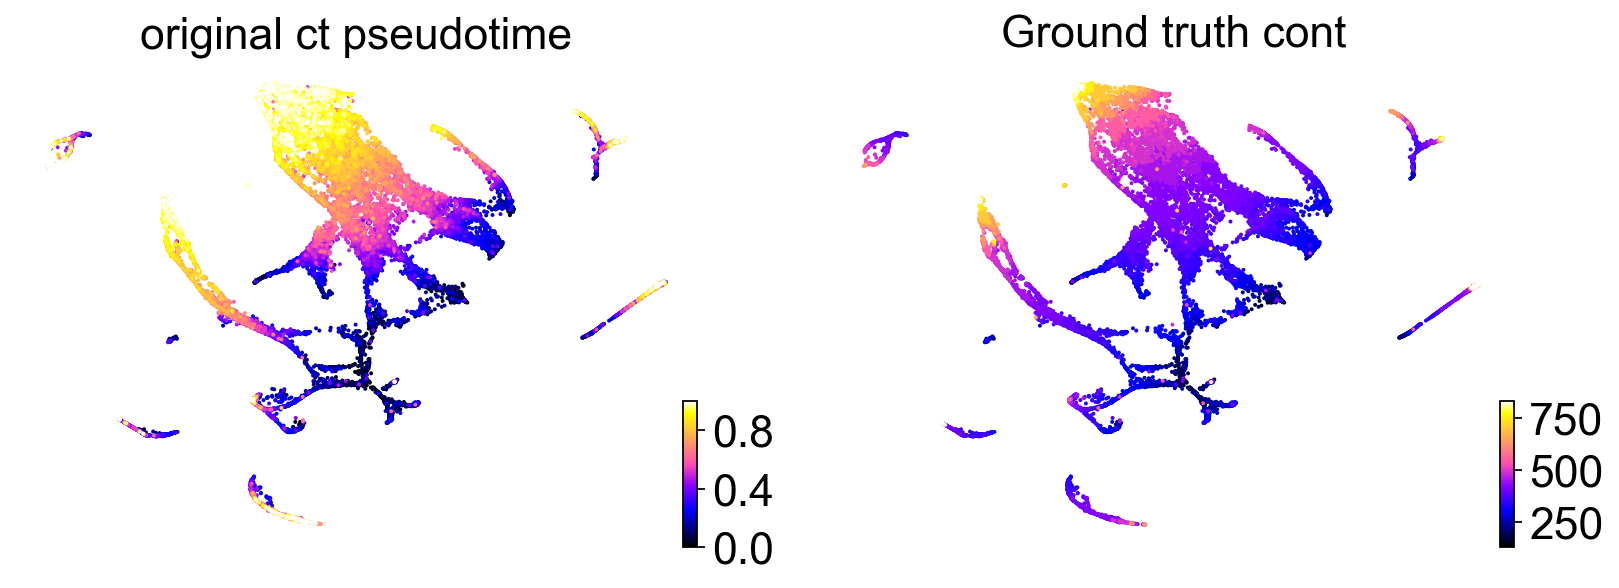

In [19]:
scv.pl.scatter(adata, c=['original_ct_pseudotime', 'Ground_truth_cont'], basis='ct', color_map='gnuplot2',
               legend_loc='right')

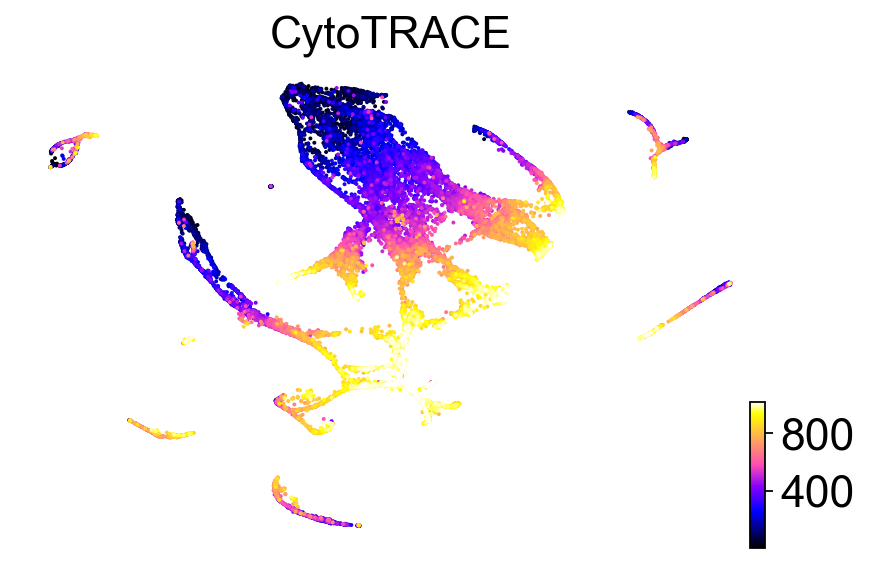

In [21]:
scv.pl.scatter(adata, c=['CytoTRACE'], basis='ct', color_map='gnuplot2',
               legend_loc='right')

## Write data to file

Write the final AnnData object to file for faster loading in the future. 

In [22]:
adata.write(DATA_DIR / "c_elegans" / "ML-2023-07-17_muscle_and_mesoderm_merged.h5ad", compression="gzip")